In [1]:
import logging
logger = logging.getLogger('retrain_ipynb')
logger.setLevel(logging.DEBUG)


ch = logging.StreamHandler()
ch.setLevel(logging.INFO)
formatter = logging.Formatter('%(levelname)s - %(asctime)s - %(name)s - %(message)s')
ch.setFormatter(formatter)
logger.addHandler(ch)
logger.debug('--=logging started=--')

In [2]:
import sys
TRAIN = True
IN_COLAB = 'google.colab' in sys.modules
print ('Running in colab:', IN_COLAB)

Running in colab: False


In [3]:
import os

if not IN_COLAB:
  nb_dir = os.path.split(os.getcwd())[0]
  if nb_dir not in sys.path:
      sys.path.append(nb_dir)
else:
  %tensorflow_version 1.x
  import tensorflow as tf
  print(tf.__version__)

In [4]:
if IN_COLAB:
  !pip install --upgrade pip
  !pip --version
  !pip install --no-deps --upgrade git+https://www.github.com/nemoware/analyser.git@uber-models
  !pip install -q pyjarowinkler overrides
  

In [5]:

if not IN_COLAB:
  import analyser.hyperparams  
  _work_dir_default = os.path.realpath(os.path.join(  analyser.hyperparams.__file__, '..', '..', '..', 'work'))
  work_dir = os.environ.get('GPN_WORK_DIR', _work_dir_default)
  
  if not os.path.isdir(work_dir):
    os.mkdir(work_dir)

  analyser.hyperparams.work_dir = work_dir
else:
  import analyser.hyperparams
  from google.colab import drive
  drive.mount('/content/drive')
  os.environ['GPN_WORK_DIR']='/content/drive/My Drive/GazpromOil/trainsets/uber_2'
  analyser.hyperparams.work_dir = os.environ['GPN_WORK_DIR']

print('work_dir=', analyser.hyperparams.work_dir)
assert os.path.isdir(analyser.hyperparams.work_dir)

Nemoware Analyser v22.12.6.1


/Users/artem/work/nemo/analyser/analyser/hyperparams.py:15: UserWarning: please set GPN_WORK_DIR environment variable
  warnings.warn('please set GPN_WORK_DIR environment variable')


USING WORKDIR: [/Users/artem/work/nemo/work]
 set ENV GPN_WORK_DIR to override
datasets_dir: [/Users/artem/work/nemo/work/datasets]
reports_dir: [/Users/artem/work/nemo/work/reports]
work_dir= /Users/artem/work/nemo/work


# Imports

In [6]:
%matplotlib inline
import tensorflow as tf
print(tf.__version__)

 
import os
import random
import math
import json
import warnings

from os import path

import seaborn as sns
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML

from colab_support.renderer import *

import pickle
import numpy as np
import pandas as pd

from bson import json_util

from analyser.legal_docs import LegalDocument, make_headline_attention_vector
from analyser.headers_detector import make_predicted_headline_attention_vector, get_tokens_features
from analyser.hyperparams import models_path
from analyser.text_tools import find_top_spans
from analyser.persistence import DbJsonDoc

from trainsets.trainset_tools import TrainsetBalancer, SubjectTrainsetManager
from trainsets.retrain_contract_uber_model import UberModelTrainsetManager

from tf_support import super_contract_model
from tf_support.super_contract_model import get_base_model, semantic_map_keys_contract
from tf_support.super_contract_model import uber_detection_model_005_1_1
from tf_support.tf_subject_model import decode_subj_prediction
from tf_support.tools import KerasTrainingContext
# from tf_support.embedder_elmo import ElmoEmbedder


from keras.utils.vis_utils import model_to_dot
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
 
from keras.models import load_model


from tensorflow import keras
import keras.backend as K
from keras.layers import Conv1D, LSTM, GRU, BatchNormalization, TimeDistributed, Dense, Bidirectional, Input, Dropout, Lambda
from keras.layers import concatenate, SpatialDropout1D, ActivityRegularization
from keras.layers import MaxPooling1D, Activation, ThresholdedReLU, GaussianNoise

from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from keras.models import Sequential, Model

# from keras.utils import plot_model
from keras.preprocessing.sequence import pad_sequences


2.5.0


[documents.py:270 -             __init__() ] loading word cases stats model from: /Users/artem/work/nemo/analyser/analyser/vocab/word_cases_stats.pickle


HyperParameters.subsidiary_name_match_min_jaro_similarity 0.9649122807017544


[currencies.py:17 -             _env_var() ] Currency-service : define GPN_CURRENCY_USER environment variable! defaulting to None
[currencies.py:17 -             _env_var() ] Currency-service : define GPN_CURRENCY_PASSWORD environment variable! defaulting to None
[currencies.py:17 -             _env_var() ] Currency-service : define GPN_CURRENCY_URL environment variable! defaulting to None
[tools.py:29 -             __init__() ] model_checkpoint_path: /Users/artem/work/nemo/analyser/analyser/vocab


# Prepare trainset


In [7]:
if not IN_COLAB:
  from integration.db import get_mongodb_connection
  from bson.objectid import ObjectId

  def get_doc(objid):
    db = get_mongodb_connection()
    documents_collection = db['documents']
    jdata = documents_collection.find_one({'_id': ObjectId(objid)})
    return DbJsonDoc(jdata)

In [8]:
if False:
    jdoc = get_doc('5df1f44dec85d861954efc47')
    doc = jdoc.asLegalDoc()
    doc.tokens
    
from pathlib import Path
work_dir = Path(analyser.hyperparams.work_dir)
print(work_dir)

/Users/artem/work/nemo/work


In [9]:
# AAAA doc.tokens

In [10]:
umtm = UberModelTrainsetManager (work_dir)

umtm.load_contract_trainset_meta() # 'contract_trainset_meta.csv'
stats = umtm.stats
stats

,url,version,org-1-name,org-2-name,org-1-alias,org-2-alias,subject,value,user_correction_date,analyze_date,...,valid,currency,len,source,unseen,score,hash,dups,subject_weight,sample_weight
_id,,,,,,,,,,,,,,,,,,,,,
5ec2b8da665f7603e03b1255,http://gpn-audit.nemosoft.ru/#/audit/edit/5ec2...,1.6.5,газпромнефть научно-технический центр,sun,гпн,sun,GeneralContract,2.523632e+07,2021-10-29 17:26:09.941000,2020-05-18 17:16:38.114000,...,True,NaN,5840.0,db,False,4.377364e-01,8.014645e+18,1.0,0.647053,5.221760
5edbc62eda3678279fbcadf3,http://gpn-audit.nemosoft.ru/#/audit/edit/5edb...,2.0.2,газпромнефть-сахалин,управление недвижимостью,доверитель,поверенный,AgencyContract,2.400000e+04,2020-07-18 12:24:26.280000+00:00,2020-07-18 20:24:58.934000+00:00,...,True,RUB,1370.0,file,False,6.262311e-01,-5.888852e+18,1.0,0.939284,3.244110
5ded4e284ddc27bcf92dd6ce,http://gpn-audit.nemosoft.ru/#/audit/edit/5ded...,1.11.2,газпромнефть-мнпз,центр развития ребенка - детский сад № 135 гор...,даритель,одаряемый,Charity,5.900000e+05,2020-06-09 00:40:54.752000+00:00,2020-06-12 21:09:19.574000+00:00,...,True,RUB,460.0,file,False,7.228859e-01,7.175818e+18,1.0,1.992736,4.138425
5ec2b8da665f7603e03b127d,http://gpn-audit.nemosoft.ru/#/audit/edit/5ec2...,2.3.14,сбербанк россии,оск,кредитор,проект,Renting,1.394400e+10,2020-09-10 11:10:15.402000,2020-09-10 11:10:43.308000,...,True,RUB,12170.0,db,False,7.235331e-01,-2.711220e+18,1.0,1.655773,7.073448
5ec2b8da665f7603e03b127e,http://gpn-audit.nemosoft.ru/#/audit/edit/5ec2...,1.6.5,газпромнефть марин бункер,газпромбанк,принципал,гарант,BankGuarantees,1.000000e+09,2021-10-29 16:28:20.936000,2020-05-18 18:26:50.950000,...,True,RUB,4760.0,db,False,1.359308e+00,-5.777985e+18,1.0,3.677836,6.293349
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5fb376ebd8c9df1ed123740f,http://gpn-audit.nemosoft.ru/#/audit/edit/5fb3...,2.5.3,NaN,NaN,,,Other,NaN,NaN,2021-10-28 16:04:55.773000,...,True,NaN,1930.0,db,True,1.440000e+08,-1.716527e+18,1.0,0.904249,0.034230
5fb376e7d8c9df1ed123733b,http://gpn-audit.nemosoft.ru/#/audit/edit/5fb3...,2.5.3,NaN,NaN,,,Other,NaN,NaN,2021-10-28 15:51:49.753000,...,True,NaN,1590.0,db,True,1.440000e+08,-1.709671e+18,1.0,1.428464,0.046918
635f684d1a481a083d947739,http://gpn-audit.nemosoft.ru/#/audit/edit/635f...,3.0.0,NaN,NaN,,,Other,NaN,NaN,2022-10-31 14:19:18.614000,...,True,NaN,1510.0,db,True,1.440000e+08,-6.032977e+18,1.0,0.944292,0.072614


In [11]:
print(len(stats))

3532


In [12]:
# if not IN_COLAB:
#     umtm.import_recent_contracts()

# Weights: вычисление весов samples  

чтобы всех запутать, 
 - вес пропорционален логорифму цены контракта (чтобы было меньше ошибок в контрактах на большие суммы)
 - more weight for user-corrected datapoints
 - normalize weights, so the sum == Number of samples

In [13]:
from trainsets.trainset_tools import get_feature_log_weights

stats = umtm.stats
subject_weights = get_feature_log_weights(stats, 'subject')
subject_weights*=subject_weights

for i, row in stats.iterrows():
  subj_name = row['subject']

  sample_weight = 0.5 
  if not pd.isna(row['user_correction_date']):  # more weight for user-corrected datapoints
    sample_weight = 5.0   # TODO: must be estimated anyhow smartly

  value_weight = 1.0
  if not pd.isna(row['value_log1p']):
    # чтобы всех запутать, вес пропорционален логорифму цены контракта
    # (чтобы было меньше ошибок в контрактах на большие суммы)
    value_weight = 1.0 + row['value_log1p']

  sample_weight *=  value_weight 
  subject_weight =  subject_weights[subj_name] 
  stats.at[i, 'subject_weight'] = subject_weight + random.random()
  stats.at[i, 'sample_weight'] = sample_weight + random.random()

# normalize weights, so the sum == Number of samples
stats.sample_weight /= stats.sample_weight.mean()
stats.subject_weight /= stats.subject_weight.mean()

print(stats.sample_weight.mean())
print(stats.subject_weight.mean())
print(stats.sample_weight.min())
print(stats.subject_weight.min())
print(stats.sample_weight.max())
print(stats.subject_weight.max())

stats.to_csv( work_dir / 'contract_trainset_meta.csv', index=True)

subject_weights

1.0000000000000002
1.0
0.028894675166109766
0.2924689501020985
7.257261691975237
5.061793092846564


Service                              0.252396
Other                                0.268804
Deal                                 0.361605
GeneralContract                      0.540685
Renting                              0.584310
Loans                                0.648886
AgencyContract                       0.736484
Insurance                            0.837610
DealIntellectualProperty             0.900736
Charity                              0.970282
RealEstate                           1.044534
RealEstateTransactions               1.471231
BankGuarantees                       2.296289
PledgeEncumbrance                    3.053469
ParticipationInOtherOrganizations    3.486915
Name: subject, dtype: float64

In [14]:
from tf_support.super_contract_model import make_xyw

# from functools import lru_cache

# def _dp_fn(doc_id, suffix):
#     return os.path.join(work_dir, 'datasets', f'{doc_id}-datapoint-{suffix}.npy')



# @lru_cache(maxsize=72)
# def make_xyw(doc_id):

#     row = stats.loc[doc_id]

#     _subj = row['subject']
#     subject_one_hot = ContractSubject.encode_1_hot()[_subj]

#     embeddings =     np.load(_dp_fn(doc_id, 'embeddings'))
#     token_features = np.load(_dp_fn(doc_id, 'token_features'))
#     semantic_map =   np.load(_dp_fn(doc_id, 'semantic_map'))

#     if embeddings.shape[0] != token_features.shape[0]:
#       msg = f'{doc_id} embeddings.shape {embeddings.shape} is incompatible with token_features.shape {token_features.shape}'
#       raise AssertionError(msg)

#     if embeddings.shape[0] != semantic_map.shape[0]:
#       msg = f'{doc_id} embeddings.shape {embeddings.shape} is incompatible with semantic_map.shape {semantic_map.shape}'
#       raise AssertionError(msg)

#     stats.at[doc_id, 'error'] = None
    
#     return (
#       (embeddings, token_features),
#       (semantic_map, subject_one_hot),
#       (row['sample_weight'], row['subject_weight']))

# Validating training set

In [15]:
%%time


from tf_support.super_contract_model import  validate_datapoint

stats['valid'] = True
stats['error'] = ''

for i in stats.index:
  
  try:
    validate_datapoint(str(i), stats)

  except Exception as e:
    logger.error(e)

    stats.at[i, 'valid'] = False
    stats.at[i, 'error'] = str(e)
    
stats

 


umtm.stats = umtm.stats[  pd.isna(umtm.stats.value_span) + (umtm.stats.value_span < 10000) ] #remove big docs from TS
stats_valid = stats[stats['valid']]
del stats
print(len(stats_valid))
umtm.stats = stats = stats_valid

ERROR - 2022-12-07 15:07:41,322 - retrain_ipynb - semantic map shape is 14, expected is 30 source=db
ERROR - 2022-12-07 15:07:41,554 - retrain_ipynb - [Errno 2] No such file or directory: '/Users/artem/work/nemo/work/datasets/637e09e512a2c61b802ba034-datapoint-embeddings.npy'
ERROR - 2022-12-07 15:07:41,554 - retrain_ipynb - [Errno 2] No such file or directory: '/Users/artem/work/nemo/work/datasets/637f7bf0e712cc2ff2e943d3-datapoint-embeddings.npy'
ERROR - 2022-12-07 15:07:41,631 - retrain_ipynb - [Errno 2] No such file or directory: '/Users/artem/work/nemo/work/datasets/635f68511a481a083d94777d-datapoint-embeddings.npy'
ERROR - 2022-12-07 15:07:42,145 - retrain_ipynb - [Errno 2] No such file or directory: '/Users/artem/work/nemo/work/datasets/635f68501a481a083d94776b-datapoint-embeddings.npy'
ERROR - 2022-12-07 15:07:42,325 - retrain_ipynb - [Errno 2] No such file or directory: '/Users/artem/work/nemo/work/datasets/637229e41a522a418c49c523-datapoint-embeddings.npy'
ERROR - 2022-12-07 

3413
CPU times: user 2.89 s, sys: 14.7 s, total: 17.6 s
Wall time: 31.4 s


In [16]:
len(stats_valid)

3413

In [17]:
print(stats.sample_weight.mean())
print(stats.subject_weight.mean())

stats.sample_weight /= stats.sample_weight.mean()
stats.subject_weight /= stats.subject_weight.mean()


print(stats.subject_weight.mean())
print(stats.subject_weight.min())

print('\n\nsample_weight')
print('MIN\t', stats.sample_weight.min())
print('MEAN\t', stats.sample_weight.mean())


1.0289704756508335
0.9994176843018375
1.0
0.2926393585945083


sample_weight
MIN	 0.028081150868622944
MEAN	 1.0


/Users/artem/miniforge3/envs/analyser39/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


/Users/artem/miniforge3/envs/analyser39/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


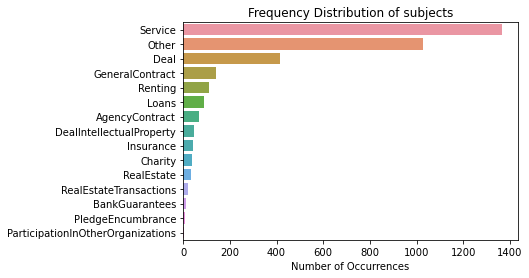


min 5
max 1366
total 3413


In [18]:
%matplotlib inline

subj_count = stats_valid['subject'].value_counts()

#plot distribution---------------------
sns.barplot(subj_count.values, subj_count.index)
plt.title('Frequency Distribution of subjects')
plt.xlabel('Number of Occurrences')
plt.show()


print ('\nmin', min (subj_count.values))
print ('max', max (subj_count.values))
print ('total', sum (subj_count.values))

In [19]:
from sklearn.utils import class_weight
from trainsets.trainset_tools import get_feature_log_weights

_classes = stats_valid['subject'].unique().tolist()

print(f'classes: {_classes}')

# class_weights = class_weight.compute_class_weight('balanced', _classes, umtm.stats['subject'])
# class_weights = dict(zip(_classes, class_weights))


class_weights = get_feature_log_weights(stats_valid, 'subject')
class_weights

classes: ['GeneralContract', 'AgencyContract', 'Charity', 'Renting', 'BankGuarantees', 'PledgeEncumbrance', 'Loans', 'Deal', 'Service', 'DealIntellectualProperty', 'Insurance', 'ParticipationInOtherOrganizations', 'RealEstateTransactions', 'RealEstate', 'Other']


Service                              0.495803
Other                                0.516105
Deal                                 0.593848
GeneralContract                      0.724431
Renting                              0.761599
Loans                                0.799556
AgencyContract                       0.848412
DealIntellectualProperty             0.935026
Insurance                            0.940425
Charity                              0.970452
RealEstate                           1.006900
RealEstateTransactions               1.194993
BankGuarantees                       1.492926
PledgeEncumbrance                    1.721558
ParticipationInOtherOrganizations    1.997969
Name: subject, dtype: float64

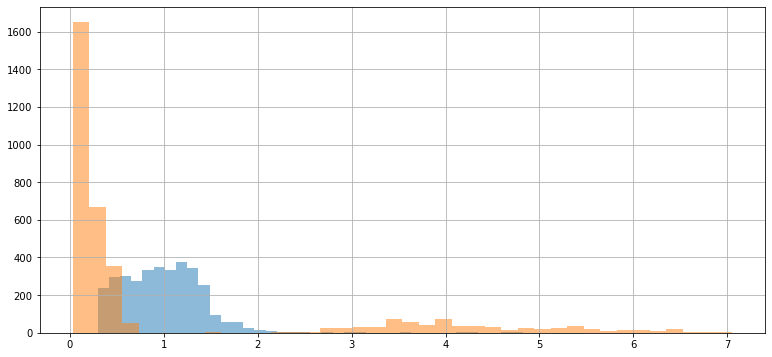

In [20]:
from trainsets.trainset_tools import get_feature_log_weights
 

plt.figure(figsize=(13, 6))

stats_valid['subject_weight'].hist(bins=40, alpha=0.5)
stats_valid['sample_weight'].hist(bins=40, alpha=0.5)

plt.xscale('linear') # log?
plt.show()

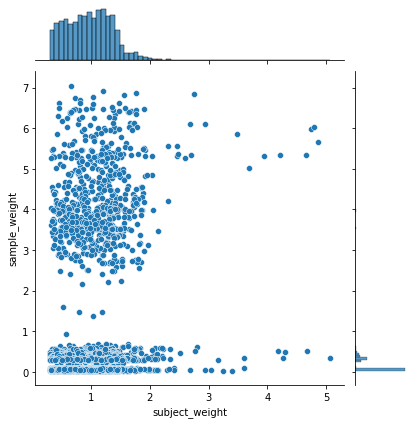

In [21]:
sns.jointplot(x="subject_weight", y="sample_weight", data=stats_valid)
plt.show()

# look into trainset (take a sample)

SAMPLE_DOC_ID 5edbc62eda3678279fbcadf3
semantic map shape is: (1373, 30)


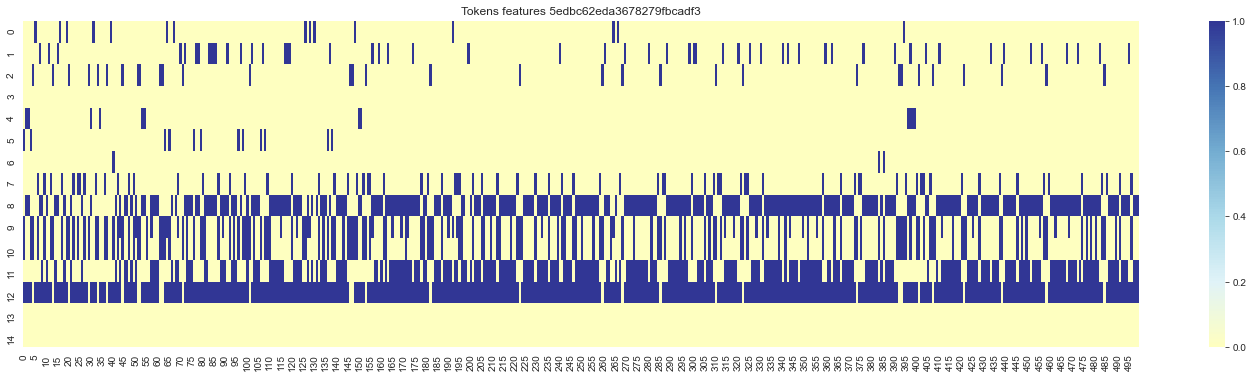

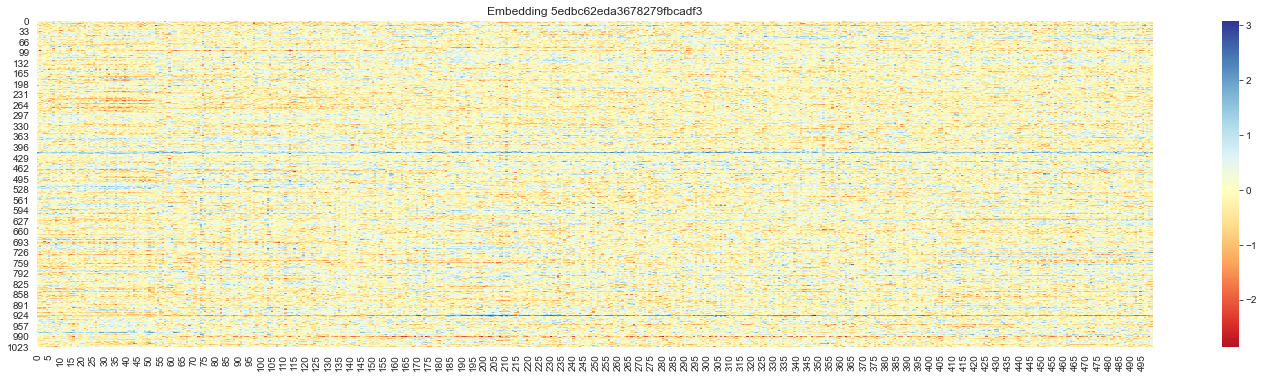

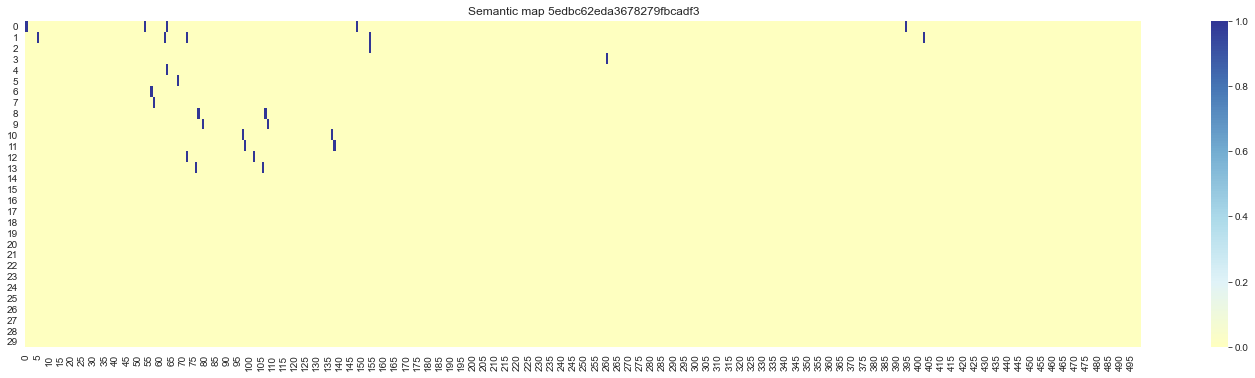

In [22]:
%matplotlib inline
# umtm.calculate_samples_weights()
SAMPLE_DOC_ID = stats_valid.index[1]

print('SAMPLE_DOC_ID', SAMPLE_DOC_ID)
(emb, tok_f), (sm, subj), (sample_weight, subject_weight) = make_xyw(SAMPLE_DOC_ID, stats)
 
    
print('semantic map shape is:', sm.shape)
_crop = 500
plot_embedding(tok_f[:_crop], title=f'Tokens features {SAMPLE_DOC_ID}') 
plot_embedding(emb[:_crop], title=f'Embedding {SAMPLE_DOC_ID}') 
plot_embedding(sm[:_crop], title=f'Semantic map {SAMPLE_DOC_ID}')



# Batch generator & TODOs 🙏


- [X] TODO: add outliers to the trainset ?
- [ ] TODO: try sparse_categorical_entropy instead of one-hot encodings
- [ ] TODO: model 5.2, 5.1: bipolar concat layer is wrong because we concatenate thongs of different magnitudes. Add a Sigmoid activation layer
- [ ] TODO: chechk what is better: to pad with zeros or to pad with means
- [X] TODO: add weights to samples
- [ ] TODO: sum semantic map alongside vertical axis, and mutiply it (as a mask) by the subject detection seq
- [ ] TODO: introduce individual per tag threshosholds, also, the current 0.3 threshold is strange.

3
semantic map shape is: (14, 1190, 30)


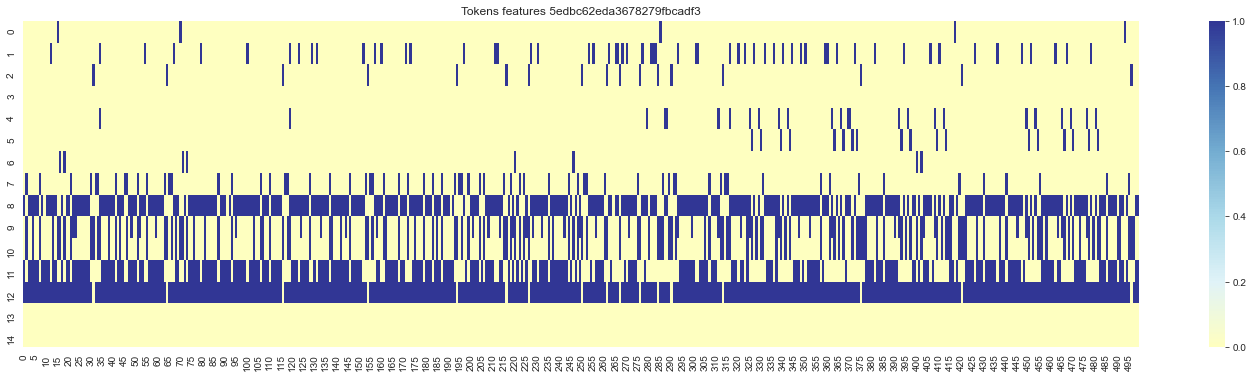

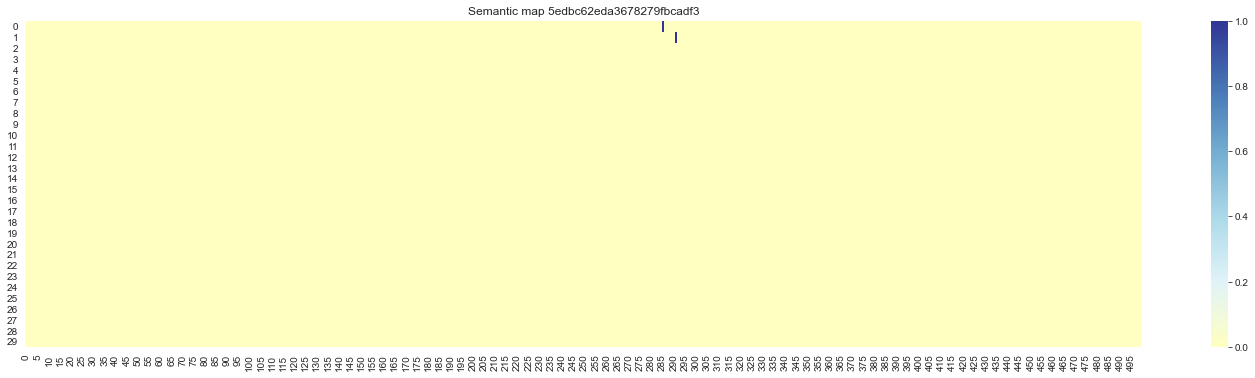

In [23]:
import numpy as np
import random
import pandas as pd

def make_generator(self, indices: [int], batch_size: int, augment_samples=False):
  np.random.seed(43)

  while True:
    # next batch
    batch_indices = np.random.choice(a=indices, size=batch_size)

    max_len = 128 * 12
    start_from = 0

    if augment_samples:
      max_len = random.randint(300, 1400)

    batch_input_emb = []
    batch_input_token_f = []
    batch_output_sm = []
    batch_output_subj = []

    weights = []
    weights_subj = []

    # Read in each input, perform preprocessing and get labels
    for doc_id in batch_indices:

      dp = make_xyw(doc_id, stats)
      (emb, tok_f), (sm, subj), (sample_weight, subject_weight) = dp
        
#       print(dp)
    
      subject_weight_K = 1.0
      if augment_samples:
        start_from = 0

        row = stats_valid.loc[doc_id]
        if random.random() < 0.4:  # 40% of samples
          segment_center = random.randint(0, len(emb) - 1)  ##select random token as a center
          if not pd.isna(row['value_span']) and random.random() < 0.7:
            segment_center = int(row['value_span'])

          _off = random.randint(max_len // 4, max_len // 2)
          start_from = segment_center - _off
          if start_from < 0:
            start_from = 0
          subject_weight_K = 0.1  # lower subject weight because there mighе be no information about subject around doc. value
        
      dp = self.trim_maxlen(dp, start_from, max_len)
      
      # TODO: find samples maxlen

      (emb, tok_f), (sm, subj), (sample_weight, subject_weight) = dp
#       print((sample_weight, subject_weight))
      subject_weight *= subject_weight_K

      batch_input_emb.append(emb)
      batch_input_token_f.append(tok_f)

      batch_output_sm.append(sm)
      batch_output_subj.append(subj)

      if np.isnan(sample_weight):
        raise ValueError()

      if np.isnan(subject_weight):
        raise ValueError()
      
      weights.append(sample_weight)
      weights_subj.append(subject_weight)
      # end if emb
    # end for loop

    # Returns a tuple of (input, output, weights) to feed the network
#     print('batch_output_subj', len(batch_output_subj))
#     print('batch_output_sm', len(batch_output_subj))
    yield ([np.array(batch_input_emb), np.array(batch_input_token_f)],
           [np.array(batch_output_sm), np.array(batch_output_subj)],
           [np.array(weights), np.array(weights_subj)])
    

    
_train, _test = train_test_split(stats_valid, test_size=0.22, stratify=stats_valid[['subject']])

train_indices = list(_train.index)
test_indices = list(_test.index)

    
####---test
_gen = make_generator(umtm, train_indices, 14, augment_samples=True)

sample = next(_gen)
print(len(sample))
del _gen
 


(emb, tok_f), (sm, subj), (sample_weight, subject_weight) = sample
 
    
print('semantic map shape is:', sm.shape)
_crop = 500
plot_embedding(tok_f[0][:_crop], title=f'Tokens features {SAMPLE_DOC_ID}') 
# plot_embedding(emb[:_crop],   title=f'Embedding {SAMPLE_DOC_ID}') 
plot_embedding(sm[0][:_crop],    title=f'Semantic map {SAMPLE_DOC_ID}')

train_indices[0]: 5eea27a9c28b75807f3daddb
test_indices[0]: 5efe924e777d4b67a92d55b2


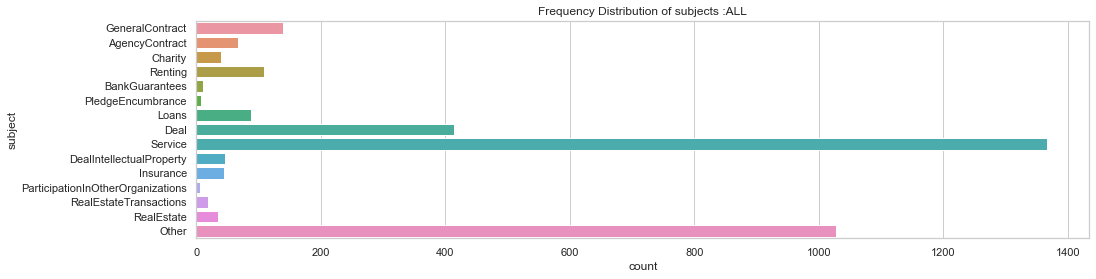

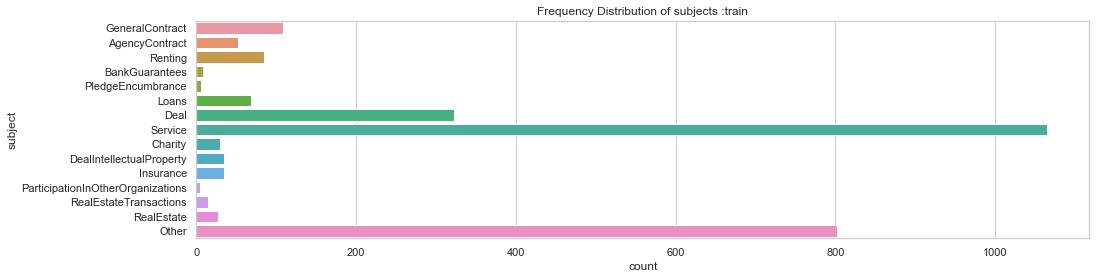

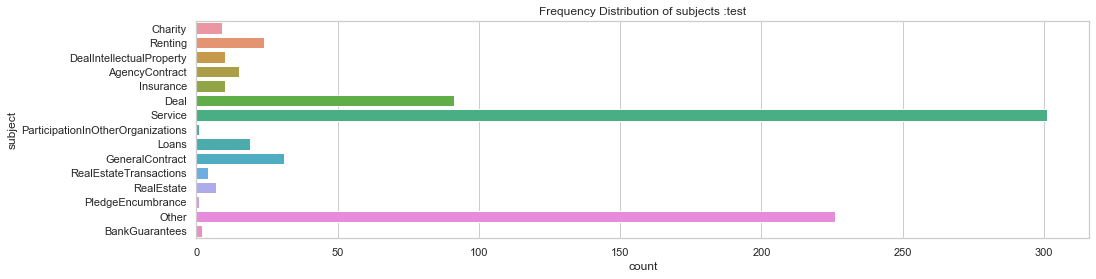

In [24]:
EPOCHS = 50
BATCH_SIZE = 24
EMB =  1024
 
_SELFTEST = True


print('train_indices[0]:', train_indices[0])
print('test_indices[0]:', test_indices[0])


def plot_subject_distr(df, title):  
  target='subject'
  plt.figure(figsize=(16,4))   
  sns.set(style="whitegrid")
  chart = sns.countplot(data=df, y=target)
  plt.title(f'Frequency Distribution of subjects :{title}')

 
plot_subject_distr(stats_valid, 'ALL')
plot_subject_distr(stats_valid[stats_valid.index.isin(train_indices)], 'train')
plot_subject_distr(stats_valid[stats_valid.index.isin(test_indices)], 'test')


if _SELFTEST:
  # test_gen = make_generator(umtm, test_indices, BATCH_SIZE)
  train_gen = make_generator(umtm, train_indices, BATCH_SIZE, augment_samples=True)
  
  x, y, w = next(train_gen)
  
#   print('X:', len(x), 'X[0]=', x[0].shape, 'X[1]=', x[1].shape)
#   print('Y:', len(y), 'Y[0]=', y[0].shape, 'Y[1]=', y[1].shape)
  

#   plot_embedding(x[0][0], 'X2: Token Embeddings')
#   plot_embedding(x[1][0], 'X1: Token Features')
#   plot_embedding(y[0][0], 'Y: Semantic Map')
  
#   print(y[0][1])

#   del x
#   del w
#   del y
#   del train_gen

In [25]:

ctx = KerasTrainingContext(umtm.work_dir, session_index=21)

ctx.set_batch_size_and_trainset_size(BATCH_SIZE, 
                                     len(test_indices), 
                                     4 * len(train_indices))

DEFAULT_TRAIN_CTX = ctx
CLASSES = 43
FEATURES = 14

metrics = ['kullback_leibler_divergence', 'mse', 'binary_crossentropy']


def train(umodel):
  test_gen = make_generator(umtm, test_indices, BATCH_SIZE)
  train_gen = make_generator(umtm, train_indices, BATCH_SIZE, augment_samples=True) 
  ctx.train_and_evaluate_model(umodel, generator=train_gen, test_generator=test_gen)

def overtrain(umodel):
  test_gen = make_generator(umtm, list(train_indices) + list(test_indices), BATCH_SIZE)
  train_gen = make_generator(umtm, list(train_indices) + list(test_indices), BATCH_SIZE, augment_samples=True) 
  ctx.train_and_evaluate_model(umodel, generator=train_gen, test_generator=test_gen)


[tools.py:29 -             __init__() ] model_checkpoint_path: /Users/artem/work/nemo/work


batch_size:	24
train_samples:	10648
test_samples:	751
steps_per_epoch:	443
validation_steps:	221


In [26]:
def init_model(model_fn) -> (Model, KerasTrainingContext):
  model_name = model_fn.__name__
  model = model_fn(name=model_name, ctx=ctx, trained=True)
#   model.name = model_name

  keras__version__ = keras.__version__
  ch_fn = os.path.join(models_path, f"{model_name}-{keras__version__}.h5")
  ch_fn_new = os.path.join(umtm.work_dir, f"{model_name}-{keras__version__}.h5")

  weights_file_old = ch_fn # os.path.join(models_path, model_name + ".weights")
  weights_file_new = ch_fn_new #os.path.join(umtm.work_dir, model_name + ".weights")

  try:
    model.load_weights(weights_file_old, by_name=True )
    logger.info(f'weights loaded: {weights_file_new}')

  except:
    msg = f'cannot load  {model_name} from  {weights_file_new}'
    warnings.warn(msg)
    logger.warning(msg)
    model.load_weights(weights_file_old, by_name=True )
    logger.info(f'weights loaded: {weights_file_old}')

  # freeze bottom 6 layers, including 'embedding_reduced' #TODO: this must be model-specific parameter
  for l in model.layers[0:6]:
    l.trainable = False

  model.compile(loss=super_contract_model.losses, optimizer='Nadam', metrics=super_contract_model.metrics)
  model.summary()

  return model
# from tf_support.tools import KerasTrainingContext


# kctx = KerasTrainingContext()

# Models 🦖

## Trainf from 0 uber_detection_model_003

In [28]:
from tf_support.super_contract_model import uber_detection_model_003


In [26]:
model_factory_fn = uber_detection_model_003
umodel = ctx.init_model(model_factory_fn, trained=True, trainable=True, load_weights=False )

umodel.summary()

if TRAIN:
  test_gen = make_generator(umtm, test_indices, BATCH_SIZE)
  train_gen = make_generator(umtm, train_indices, BATCH_SIZE, augment_samples=True) 

  ctx.EPOCHS = 20
  ctx.EVALUATE_ONLY = False
  ctx.train_and_evaluate_model(umodel, generator=train_gen, test_generator=test_gen, retrain=True)

Model: "uber_detection_model_003"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_text_emb (InputLayer)     [(None, None, 1024)] 0                                            
__________________________________________________________________________________________________
drops (Dropout)                 (None, None, 1024)   0           input_text_emb[0][0]             
__________________________________________________________________________________________________
input_headlines_att (InputLayer [(None, None, 15)]   0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, None, 1039)   0           drops[0][0]                      
                                                                 input_head

/Users/artem/miniforge3/envs/analyser39/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
2022-12-04 23:34:25.385308: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-12-04 23:34:25.386654: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


444/444 [==============================] - 470s 1s/step - loss: 0.1239 - O1_tagging_loss: 0.0325 - O2_subject_loss: 0.0913 - O1_tagging_kullback_leibler_divergence: 0.0397 - O1_tagging_mse: 0.0052 - O1_tagging_binary_crossentropy: 0.0610 - O2_subject_kullback_leibler_divergence: 2.4244 - O2_subject_mse: 0.0190 - O2_subject_binary_crossentropy: 0.1355 - val_loss: 0.0811 - val_O1_tagging_loss: 0.0119 - val_O2_subject_loss: 0.0691 - val_O1_tagging_kullback_leibler_divergence: 0.0190 - val_O1_tagging_mse: 0.0023 - val_O1_tagging_binary_crossentropy: 0.0423 - val_O2_subject_kullback_leibler_divergence: 1.8175 - val_O2_subject_mse: 0.0171 - val_O2_subject_binary_crossentropy: 0.0636

Epoch 00001: val_loss improved from inf to 0.08107, saving model to /Users/artem/work/nemo/work/uber_detection_model_003.h5
Epoch 2/20
444/444 [==============================] - 1826s 4s/step - loss: 0.0548 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0431 - O1_tagging_kullback_leibler_divergence: 0.0237 - O1_

## Continue training 003 from checkpoint

In [27]:
model_factory_fn = uber_detection_model_003

weights = ctx.model_checkpoint_path / f'{model_factory_fn.__name__}.h5'
print(weights.is_file())
print(weights)
umodel = ctx.init_model(model_factory_fn, trained=True, trainable=True, weights=weights)

if TRAIN:
  test_gen = make_generator(umtm, test_indices, BATCH_SIZE)
  train_gen = make_generator(umtm, train_indices, BATCH_SIZE, augment_samples=True) 

  ctx.EPOCHS = 25
  ctx.EVALUATE_ONLY = False
  ctx.train_and_evaluate_model(umodel, generator=train_gen, test_generator=test_gen, retrain=True)

True
/Users/artem/work/nemo/work/uber_detection_model_003.h5


[tools.py:121 -           init_model() ] weights loaded: /Users/artem/work/nemo/work/uber_detection_model_003.h5


model.name == uber_detection_model_003
continue: lr:0.0010000000474974513, epoch:0
Epoch 1/25
444/444 [==============================] - 1957s 4s/step - loss: 0.0302 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0253 - O1_tagging_kullback_leibler_divergence: 0.0158 - O1_tagging_mse: 5.1554e-04 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_kullback_leibler_divergence: 1.0836 - O2_subject_mse: 0.0110 - O2_subject_binary_crossentropy: 0.0387 - val_loss: 0.0388 - val_O1_tagging_loss: 0.0033 - val_O2_subject_loss: 0.0355 - val_O1_tagging_kullback_leibler_divergence: 0.0069 - val_O1_tagging_mse: 4.0453e-04 - val_O1_tagging_binary_crossentropy: 0.0092 - val_O2_subject_kullback_leibler_divergence: 0.8530 - val_O2_subject_mse: 0.0088 - val_O2_subject_binary_crossentropy: 0.0313

Epoch 00001: val_loss improved from inf to 0.03876, saving model to /Users/artem/work/nemo/work/uber_detection_model_003.h5
Epoch 2/25
444/444 [==============================] - 1111s 3s/step - loss: 0.0295 - O

## Overtrain 003

In [ ]:
if TRAIN:
  ctx.unfreezeModel(umodel)
  umodel.compile(loss=super_contract_model.losses, optimizer='Nadam', metrics=super_contract_model.metrics)
  print(super_contract_model.losses)
  umodel.summary()
  
  ctx.EPOCHS = 25
  ctx.EVALUATE_ONLY = False
  ctx.EPOCHS *= 2

  test_gen = make_generator(umtm, train_indices, BATCH_SIZE)
  train_gen = make_generator(umtm, train_indices + test_indices, BATCH_SIZE, augment_samples=True) 
  
  ctx.train_and_evaluate_model(umodel, train_gen, test_generator=test_gen, retrain=False, lr=2e-5)

## uber_detection_model_005


In [28]:
model_factory_fn = uber_detection_model_005_1_1
umodel = ctx.init_model(model_factory_fn, trained=True, trainable=True, load_weights=False )

umodel.summary()

if TRAIN:
  test_gen = make_generator(umtm, test_indices, BATCH_SIZE)
  train_gen = make_generator(umtm, train_indices, BATCH_SIZE, augment_samples=True) 

  ctx.EPOCHS = 25
  ctx.EVALUATE_ONLY = False
  ctx.train_and_evaluate_model(umodel, generator=train_gen, test_generator=test_gen, retrain=True)

Model: "uber_detection_model_005_1_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_text_emb (InputLayer)     [(None, None, 1024)] 0                                            
__________________________________________________________________________________________________
drops (Dropout)                 (None, None, 1024)   0           input_text_emb[0][0]             
__________________________________________________________________________________________________
input_headlines_att (InputLayer [(None, None, 15)]   0                                            
__________________________________________________________________________________________________
concatenate_2 (Concatenate)     (None, None, 1039)   0           drops[0][0]                      
                                                                 input_

### 5.1.1 💕💕 uber_detection_model_005_1_1

In [29]:
from pathlib import Path

model_factory_fn = uber_detection_model_005_1_1
# weights = Path(models_path) / f"{model_factory_fn.__name__}-{keras.__version__}.h5"
weights = ctx.model_checkpoint_path / f'{model_factory_fn.__name__}.h5'

print(weights)
print(weights.is_file())

/Users/artem/work/nemo/work/uber_detection_model_005_1_1.h5
True


In [30]:
# umodel = init_model(uber_detection_model_005_1_1 )
model_factory_fn = uber_detection_model_005_1_1
umodel = ctx.init_model(model_factory_fn, trained=True, trainable=True, weights=weights)

[tools.py:121 -           init_model() ] weights loaded: /Users/artem/work/nemo/work/uber_detection_model_005_1_1.h5


In [31]:
######################
# Phase I retraining
# ❄️ frozen bottom layers
######################

if TRAIN:
  test_gen = make_generator(umtm, test_indices, BATCH_SIZE)
  train_gen = make_generator(umtm, train_indices, BATCH_SIZE, augment_samples=True) 

  ctx.EPOCHS = 20
  ctx.EVALUATE_ONLY = False
  ctx.train_and_evaluate_model(umodel, generator=train_gen, test_generator=test_gen, retrain=True)

model.name == uber_detection_model_005_1_1
continue: lr:0.0010000000474974513, epoch:0
Epoch 1/20


/Users/artem/miniforge3/envs/analyser39/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
2022-12-07 15:12:20.649255: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-12-07 15:12:20.650312: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


443/443 [==============================] - 400s 899ms/step - loss: 0.0228 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0204 - O1_tagging_kullback_leibler_divergence: 0.0324 - O1_tagging_mse: 3.4331e-04 - O1_tagging_binary_crossentropy: 0.0028 - O2_subject_kullback_leibler_divergence: 0.9958 - O2_subject_mse: 0.0102 - O2_subject_binary_crossentropy: 0.0351 - val_loss: 0.0284 - val_O1_tagging_loss: 0.0019 - val_O2_subject_loss: 0.0265 - val_O1_tagging_kullback_leibler_divergence: 0.0183 - val_O1_tagging_mse: 2.2499e-04 - val_O1_tagging_binary_crossentropy: 0.0024 - val_O2_subject_kullback_leibler_divergence: 0.6160 - val_O2_subject_mse: 0.0068 - val_O2_subject_binary_crossentropy: 0.0243

Epoch 00001: val_loss improved from inf to 0.02842, saving model to /Users/artem/work/nemo/work/uber_detection_model_005_1_1.h5
Epoch 2/20
443/443 [==============================] - 477s 1s/step - loss: 0.0230 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0205 - O1_tagging_kullback_leibler_divergence

In [32]:
######################
## Phase II finetuning
#  all unfrozen, entire trainset, low LR
######################
if TRAIN:
  ctx.unfreezeModel(umodel)
  umodel.compile(loss=super_contract_model.losses, optimizer='Nadam', metrics=super_contract_model.metrics)
  umodel.summary()
  
  ctx.EPOCHS = 25
  ctx.EVALUATE_ONLY = False
  ctx.EPOCHS *= 2

  test_gen = make_generator(umtm, train_indices + test_indices, BATCH_SIZE)
  train_gen = make_generator(umtm, train_indices + test_indices, BATCH_SIZE, augment_samples=True) 
  
  ctx.train_and_evaluate_model(umodel, train_gen, test_generator=test_gen, retrain=False, lr=2e-5)

Model: "uber_detection_model_005_1_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_text_emb (InputLayer)     [(None, None, 1024)] 0                                            
__________________________________________________________________________________________________
drops (Dropout)                 (None, None, 1024)   0           input_text_emb[0][0]             
__________________________________________________________________________________________________
input_headlines_att (InputLayer [(None, None, 15)]   0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, None, 1039)   0           drops[0][0]                      
                                                                 input_

# Evaluate models

In [40]:
# def save_checkpoint(ctx, model_factory_fn):
    
#     model_name = model_factory_fn.__name__    
#     model = ctx.init_model(model_fn, trained=True, trainable=False, weights=ctx.model_checkpoint_path / f'{model_factory_fn.__name__}.weights')
#     model.summary()    


#     ch_fn = os.path.join(ctx.model_checkpoint_path, f"{model_name}-{keras.__version__}.h5")

#     if not os.path.isfile(ch_fn):
#       model.save_weights(ch_fn)
#       print(f"model weights saved to {ch_fn}")

#     else:
#       print(f"model weights NOT saved, because file exists {ch_fn}")

# save_checkpoint(ctx, uber_detection_model_005_1_1)

In [33]:
# /Users/artem/work/nemo/work/uber_detection_model_005_1_1.h5

#######################################
#######################################
model_fn = uber_detection_model_005_1_1
#######################################
#######################################

umodel = ctx.init_model(model_fn, trained=True, trainable=False, weights=ctx.model_checkpoint_path / f'{model_fn.__name__}.h5')

#TODO: remove next 2 lines
ctx.trained_models[umodel.name] = umodel.name
models = ctx.trained_models

[tools.py:121 -           init_model() ] weights loaded: /Users/artem/work/nemo/work/uber_detection_model_005_1_1.h5


### training history

loading training log from /Users/artem/work/nemo/work/uber_detection_model_005_1_1.21.log.csv


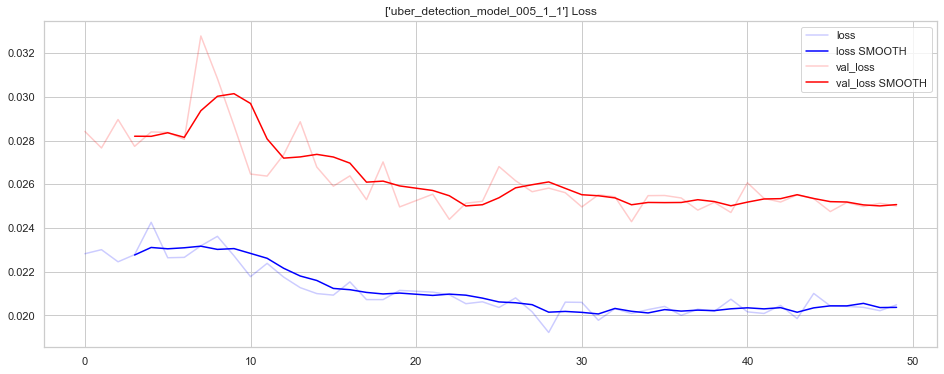

loading training log from /Users/artem/work/nemo/work/uber_detection_model_005_1_1.21.log.csv


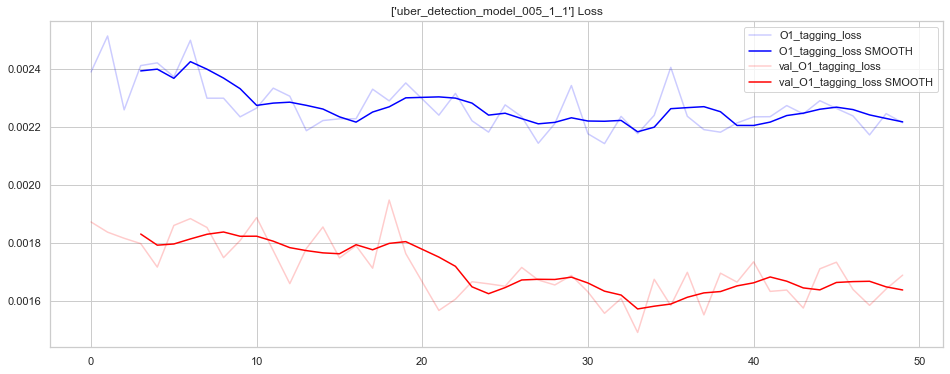

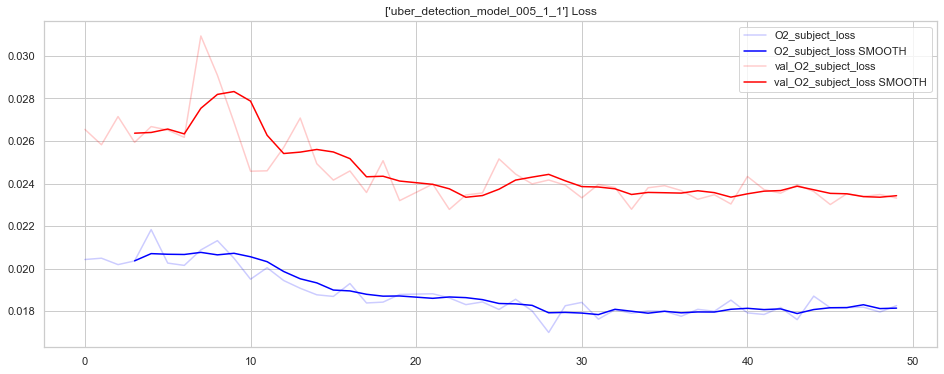

In [34]:
def plot_compare_models(
    models: [str],
    metrics, 
    title="metric/epoch",
    image_save_path = umtm.work_dir):
    
  _metrics = [m for m in metrics if not m.startswith('val_')]

  for i, m in enumerate(models):

    data: pd.DataFrame = ctx.get_log(m)

    if data is not None:
      data.set_index('epoch')

      for metric in _metrics:
        plt.figure(figsize=(16, 6))
        plt.grid(True)
        plt.title(f'{metric} [{m}]')
        for metric_variant in ['', 'val_']:
          key = metric_variant + metric
          if key in data:

            x = data['epoch'][-100:]
            y = data[key][-100:]


            c = 'red'  # plt.cm.jet_r(i * colorstep)
            if metric_variant == '':
              c = 'blue'
            plt.plot(x, y, label=f'{key}', alpha=0.2, color=c)

            y = y.rolling(4, win_type='gaussian').mean(std=4)
            plt.plot(x, y, label=f'{key} SMOOTH', color=c)

            plt.legend(loc='upper right')

        
        plt.title(f'{[m]} {title}')
        plt.grid(True)
        img_path = os.path.join(image_save_path, f'{m}-{metric}.png')
        
        plt.savefig(img_path, bbox_inches='tight')        
        plt.show()
    else:
      logger.error('cannot plot')
    

models = list(ctx.trained_models.keys())


plot_compare_models(models, ['loss'], 'Loss')

# plot_compare_models(models, ['O1_tagging_kullback_leibler_divergence'], 'TAGS: Kullback Leibler divergence')
# plot_compare_models(models, ['O1_tagging_mse'], 'TAGS: MSE')
# plot_compare_models(models, ['O2_subject_kullback_leibler_divergence'], 'Subj: Kullback Leibler divergence')
# plot_compare_models(models, ['O2_subject_mse'],  'Subjects: MSE')

plot_compare_models(models, ['O1_tagging_loss', 'O2_subject_loss'], 'Loss')



## Contract subj Confusion matrices

In [35]:
# umtm.stats
# semantic_map_keys_contract


5ded4e284ddc27bcf92dd6ce


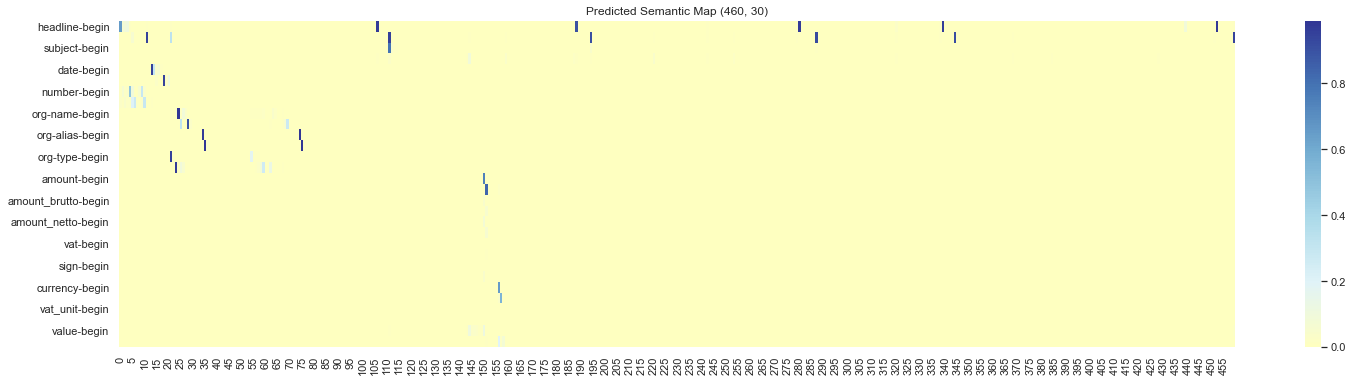

In [36]:
from tf_support.super_contract_model import make_xyw

sample_index = umtm.stats [umtm.stats['value']>0].index[2]
print(sample_index)

x, y, _ = make_xyw(sample_index, umtm.stats)

prediction = umodel.predict(x=[np.expand_dims(x[0], axis=0), np.expand_dims(x[1], axis=0)], batch_size=1)

tagsmap = pd.DataFrame(prediction[0][0], columns=semantic_map_keys_contract)
# .T
plot_embedding(tagsmap[:500], f'Predicted Semantic Map {tagsmap.shape}')

In [37]:
from analyser.contract_parser import nn_get_tag_values

In [38]:

agent_tags = ['org-1-name',
              'org-1-type',
              'org-1-alias',
              'org-2-name',
              'org-2-type',
              'org-2-alias']
solo_tags = [
  'date',
  'number',
  'sign_value_currency/value',
  'sign_value_currency/currency',
  'sign_value_currency/sign'
]

# seq_labels_contract[-3:]

tagnames = solo_tags + agent_tags


from pandas import DataFrame

from analyser.contract_agents import ContractAgent, normalize_contract_agent
from analyser.documents import TextMap
from analyser.ml_tools import SemanticTag
from analyser.persistence import DbJsonDoc
from analyser.text_tools import find_top_spans
# from tf_support.super_contract_model import seq_labels_contract
from tf_support.tf_subject_model import decode_subj_prediction

from analyser.contract_parser import nn_find_org_names, nn_get_tag_value




def fetch_tags_from_predicted_semantic_map(_id: str, tagsmap: DataFrame):
  jdoc = get_doc(_id)
  _map = jdoc.get_tokens_map_unchaged()

  results = {}
  for key in tagnames:
    t = nn_get_tag_value(key, _map, tagsmap )
    results[key] = t
    # print(t)

#   ca = ContractAgent()
#   ca.name =  results['org-1-name'] #TODO: check for NONE
#   ca.type =  results['org-1-type']
#   ca.alias = results['org-1-alias']
   

#   ca2 = ContractAgent()
#   ca2.name =  results['org-2-name'] #TODO: check for NONE
#   ca2.type =  results['org-2-type']
#   ca2.alias = results['org-2-alias']
#   try:
#     normalize_contract_agent(ca)
#     normalize_contract_agent(ca2)
#   except Exception as e:
#         # TODO:
#     logger.error(f'{_id} {e}')

  if results['number'] is not None:
    results['number'].value = results['number'].value.strip().lstrip('№').lstrip('N ').lstrip()

  return results, jdoc


def put_results_into_df(id_, results, df, jdoc: DbJsonDoc):
  org_atribs = ['name', 'alias', 'type']

  def v(x):
    if results[x] is not None:
      return results[x].value

  def swap(a, b):
    ab = [a, b]
    try:
      ab = sorted(ab)
    except:
      pass
    return ab

  def s(a, b):
    ab = swap(v(a), v(b))
    df.at[id_, f'p-{a}'] = ab[0]
    df.at[id_, f'p-{b}'] = ab[1]
    return ab

  for key in org_atribs:
    arr = s(f'org-1-{key}', f'org-2-{key}')

  def p(key):
    df.at[id_, f'p-{key}'] = v(key)

  p('sign_value_currency/value')
  p('sign_value_currency/currency')
  p('sign_value_currency/sign')

  p('date')
  p('number')

  # get_expected values
  for key in solo_tags:
    t = jdoc.get_attribute_value(key)
    df.at[id_, f'{key}'] = t

  for key in org_atribs:
    orgs = swap(jdoc.get_attribute_value(f'org-1-{key}'), jdoc.get_attribute_value(f'org-2-{key}'))
    df.at[id_, f'org-1-{key}'] = orgs[0]
    df.at[id_, f'org-2-{key}'] = orgs[1]



ImportError: cannot import name 'nn_get_tag_value' from 'analyser.contract_parser' (/Users/artem/work/nemo/analyser/analyser/contract_parser.py)

In [51]:
def make_subj_predictions(umodel, indices):
  ev = umtm.stats.copy()
  tags = pd.DataFrame()
  for t in tagnames:
    tags['p-' + t] = ''
    tags[t] = ''

  errors_report = pd.DataFrame()
  errors_report['expected'] = ''
  errors_report['predicted'] = ''

  for i, _id in enumerate(indices):
    logger.debug(f'validating {_id} {i} of {len(indices)}')
    
    x, y, _ = make_xyw(_id, umtm.stats)

    prediction = umodel.predict(x=[np.expand_dims(x[0], axis=0), np.expand_dims(x[1], axis=0)], batch_size=1)

    tagsmap = pd.DataFrame(prediction[0][0], columns=seq_labels_contract)
  
    r, jdoc = fetch_tags_from_predicted_semantic_map(_id, tagsmap)
    put_results_into_df(_id, r, tags, jdoc)
    

    subj_1hot = prediction[1][0]

    expected = decode_subj_prediction(y[1])[0]
    predicted = decode_subj_prediction(subj_1hot)[0]

    ev.at[_id, 'expected_subj'] = expected.name
    ev.at[_id, 'predicted_subj'] = predicted.name

    ev.at[_id, 'wrong'] = False
    if expected != predicted:
      ev.at[_id, 'wrong'] = True

  return ev, tags

ev, tags = make_subj_predictions(umodel, [sample_index])
tags

NameError: name 'seq_labels_contract' is not defined

In [49]:
%%time




# def fetch_tag_value(tagname: str, textmap: TextMap, tagging: DataFrame, threshold=0.3) -> SemanticTag or None:
#   att = tagging[tagname].values
#   slices = find_top_spans(att, threshold=threshold, limit=1) #TODO: estimate per-tag thresholds
  
#   if len(slices) > 0:
#     span = slices[0].start, slices[0].stop
#     value = textmap.text_range(span)
#     tag = SemanticTag(tagname, value, span)
#     tag.confidence = att[slices[0]].mean()
#     return tag
#   return None










subset = umtm.stats #umtm.stats[~pd.isna(umtm.stats['user_correction_date'])].sort_values('analyze_date')
_indices =  subset.index
ev, tags = make_subj_predictions(umodel, _indices)
tags.to_csv('all_contracts_predicstions.csv')

NameError: name 'make_subj_predictions' is not defined

In [ ]:
# subset = umtm.stats[~pd.isna(umtm.stats['user_correction_date'])]
# pd.isna(umtm.stats['user_correction_date'])
ev 

In [ ]:
# _cols = [  'wrong' ]
# _tmp = ev[cols]
# errors_report = _tmp[ _tmp.wrong == True] #.sort_values('subject')
# print(len(errors_report), 'wrong subjects of', len(tags))
# errors_report 

ev['predicted_subj']
subj_df = ev[['predicted_subj', 'expected_subj']].copy()

In [ ]:
subj_df

In [ ]:
def make_report(umodel, ev):
  plot_cm(ev['expected_subj'], ev['predicted_subj'])
  
  img_path = os.path.join(umtm.work_dir, f'subjects-confusion-matrix-{umodel.name}.png')
  plt.savefig(img_path, bbox_inches='tight')

  report = classification_report(ev['expected_subj'], ev['predicted_subj'], digits=3)
  print(umodel.name)
  print(report)
  
  with open(os.path.join(umtm.work_dir, f'subjects-classification_report-{umodel.name}.txt'), "w") as text_file:
    text_file.write(report)


subj_df = ev[['predicted_subj', 'expected_subj']].copy() #ev[~pd.isna(ev['predicted_subj'])]
make_report(umodel, subj_df)

# Evaluate tags detection

In [52]:
tags.fillna('-', inplace=True)
tags

NameError: name 'tags' is not defined

In [ ]:
def save_csv(d, f):
    fn = os.path.join(umtm.work_dir, f)
    d.to_csv(fn)

### Contract number validation

In [53]:
wrong_numbers = tags [ tags['number'] != tags['p-number']].sort_values('number')
print( f'Contract numbers: {len(wrong_numbers)} of {len(tags)}  ({100. * len(wrong_numbers) / len(tags) :0.1f}%) were detected wronggly')

save_csv( wrong_numbers[['p-number', 'number']], 'wrong_numbers.csv')

# wrong_numbers[['p-number', 'number']].tail(10)

NameError: name 'tags' is not defined

In [ ]:
tags ['sign_value_currency/currency'].head(100)

In [ ]:
def conv(x):
    if type(x) is str:
        v = x.replace(',','.').replace(' ','')
    else: 
        v=x
    try:
        v=float(v)
    except:
        v=np.nan
    return v 

tags['n-p-sign_value_currency/value'] = pd.to_numeric( tags['p-sign_value_currency/value'].apply(conv) )
tags['n-sign_value_currency/value']   = pd.to_numeric( tags['sign_value_currency/value'].apply(conv) )

In [ ]:
wrong_values = tags [  tags['n-p-sign_value_currency/value']  != tags['n-sign_value_currency/value']]
cols = ['n-p-sign_value_currency/value', 'n-sign_value_currency/value']
wrong_values = wrong_values[cols]

wrong_values ['val_err'] = \
    np.log1p( np.abs(wrong_values['n-p-sign_value_currency/value'] - wrong_values['n-sign_value_currency/value']))
wrong_values = wrong_values.sort_values('val_err', ascending=False)

print(len(wrong_values))
wrong_values.tail(24)

### Contract Org-1 validation

In [ ]:


wrong_orgs1 = tags [ (tags['org-1-name'] != tags['p-org-1-name']) | (tags['org-2-name'] != tags['p-org-2-name']) ]
print( f'Org-1 name: {len(wrong_orgs1)} of {len(tags)}  ({100. * len(wrong_orgs1) / len(tags):0.1f}%) were detected incorrectly')

cols=['p-org-1-name', 'org-1-name', 'p-org-2-name', 'org-2-name']
save_csv( wrong_orgs1[cols], 'wrong_orgs1.csv')

wrong_orgs1[cols].head(20)

In [ ]:
wrong_aliases = tags [ (tags['org-1-alias'] != tags['p-org-1-alias']) | (tags['org-2-alias'] != tags['p-org-2-alias']) ]
print( f'Aliases: {len(wrong_aliases)} of {len(tags)}  ({100. * len(wrong_aliases) / len(tags) : 0.1f}%) were detected incorrectly')

cols=['p-org-1-alias', 'org-1-alias', 'p-org-2-alias', 'org-2-alias']
save_csv( wrong_aliases[cols], 'wrong_aliases.csv')
# wrong_aliases[cols].head(10)

In [ ]:
wrong_types = tags [ (tags['org-1-type'] != tags['p-org-1-type']) | (tags['org-2-type'] != tags['p-org-2-type'])]
print( f'Types: {len(wrong_types)} of {len(tags)}  ({100. * len(wrong_types) / len(tags) : 0.1f}%) were detected incorrectly')
cols=['p-org-1-type', 'p-org-2-type', 'org-1-type', 'org-2-type']
save_csv( wrong_types[cols], 'wrong_types.csv')
wrong_types[cols].head(10)

In [ ]:
from collections import Counter
arrays = [ wrong_orgs1, wrong_types, wrong_numbers, wrong_aliases]
counter = Counter()
for a in arrays:
  for i in a.index:
   counter[i]+=1
 

print('Самый сложный документ: ', counter.most_common()[0][0])
print("Всего недочетов:", len(counter))

In [ ]:
umtm.stats['errors'] = 0
for c in counter:
  umtm.stats.at[c, 'errors'] = counter[c]


calculate_samples_weights(umtm)
umtm._save_stats()
umtm.stats

## Single doc eval

In [ ]:
if IN_COLAB:
  !wget https://raw.githubusercontent.com/nemoware/analyser/uber-models/tests/contract_db_1.json

  with open('contract_db_1.json', 'rb') as handle:    
    jdata = json.load(handle, object_hook=json_util.object_hook)

  jdoc = DbJsonDoc(jdata)

else:
  from integration.db import get_mongodb_connection
  from bson.objectid import ObjectId

  def get_doc(objid):
    logger.debug(f'fetching {objid}')
    db = get_mongodb_connection()
    documents_collection = db['documents']
    jdata =  documents_collection.find_one({'_id': ObjectId(objid)})
    return DbJsonDoc(jdata)

  SAMPLE_DOC_ID = counter.most_common()[0][0] #umtm.stats.index[10]
    
    
    
  SAMPLE_DOC_ID = '5eea27adc28b75807f3dae66'
  print('SAMPLE_DOC_ID:', SAMPLE_DOC_ID)
  dp = umtm.make_xyw(SAMPLE_DOC_ID)
  (emb, tok_f), (sm, subj), (sample_weight, subject_weight) = dp

  jdoc = get_doc(SAMPLE_DOC_ID)

In [ ]:
from analyser.legal_docs import embedd_tokens

if IN_COLAB:
  embedder = ElmoEmbedder.get_instance('elmo')  # lazy init
  emb = embedd_tokens(jdoc.get_tokens_for_embedding(),
                             embedder,
                             verbosity=2,
                             log_key='tmp')

  tok_f = get_tokens_features(jdoc.get_tokens_map_unchaged().tokens)

In [ ]:
###############
prediction = umodel.predict(   x=[  np.expand_dims(emb, axis=0), np.expand_dims(tok_f, axis=0)] , batch_size=1)
##############
print(len(prediction), umodel.name)
subj_1hot = prediction[1][0]
print('Subject:', decode_subj_prediction(subj_1hot))


tagging = pd.DataFrame( prediction[0][0], columns=seq_labels_contract)
plot_embedding(tagging, title = f'Predictions of {umodel.name}')

In [ ]:
def render_slices(slices, tokens, attention_v, ht='') -> str:
  ht += '<ol>'
  for _s in slices:
    ht += '<li>'
    t = tokens[_s]
    l = attention_v[_s]
    ht += to_color_text(t, l, _range=(0, 1.2))
    ht += '<br><hr>'
    ht += '</li>'
  ht += '</ol>'

  return ht

for t in seq_labels_contract:
  spans = list( find_top_spans( tagging[t].values, threshold=0.3))  
  display(HTML(render_slices(spans, jdoc.get_tokens_map_unchaged().tokens, tagging[t].values)))


In [ ]:

# mean_ = tagging.values.max(-1)*0.5
# print (mean_.shape)
# display(HTML( to_color_text (jdoc.get_tokens_map_unchaged().tokens[:24000],  mean_[:24000])))

In [ ]:
ids = '5edbadd7da3678279fbcaabf
5edbc660da3678279fbcaeac
5edbc668da3678279fbcaf6e
5edbc65dda3678279fbcae56
5edbc66bda3678279fbcafe6
5edbc615da3678279fbcadc9'